In [1]:
from mss import mss
import pydirectinput 
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import time
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
class dino(Env):
    def __init__(self):
        super().__init__()
        
        self.observation_space=Box(low=0,high=255,shape=(1,83,100),dtype=np.uint8)
        self.action_space=Discrete(3)
        
        self.cap=mss()
        self.game_location = {'top': 300, 'left': 0, 'width': 600, 'height': 500}
        self.done_location = {'top': 405, 'left': 630, 'width': 660, 'height': 70}
        
    def step(self, action):
        action_map={
            0:'space',
            1:'down',
            2:'no_op'
        }
        
        if action !=2:
            pydirectinput.press(action_map[action])
        
        done, done_cap=self.get_done()
        new_observation=self.get_observation()
        
        reward=1
        info={}
        
        return new_observation, reward, done, info
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150,y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('game',np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF==ord('q'):
                   self.close()
    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):
        raw=np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray=cv2.cvtColor(raw,cv2.COLOR_BGR2GRAY)
        resized=cv2.resize(gray,(100,83))
        channel=np.reshape(resized,(1,83,100))
        
        return channel
    def get_done(self):
        done_cap=np.array(self.cap.grab(self.done_location))[:,:,:3]
        done_strings=['GAME','GAHE']
        
        done=False
        res=pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done=True
        return done, done_cap

In [3]:
env=dino()

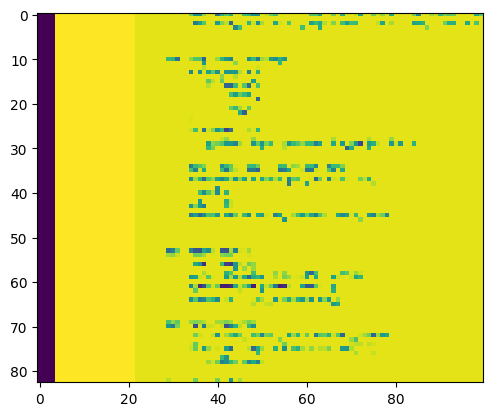

In [4]:
plt.imshow(env.get_obs()[0])

In [5]:
np.array(env.get_done())

C:\Users\vibhu\AppData\Local\Temp\ipykernel_1116\557261187.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(env.get_done())


array([False, array([[[245, 245, 245],
                      [245, 245, 245],
                      [245, 245, 245],
                      ...,
                      [247, 247, 247],
                      [247, 247, 247],
                      [128, 193, 247]],

                     [[245, 245, 245],
                      [245, 245, 245],
                      [245, 245, 245],
                      ...,
                      [247, 247, 247],
                      [247, 247, 247],
                      [128, 193, 247]],

                     [[245, 245, 245],
                      [245, 245, 245],
                      [245, 245, 245],
                      ...,
                      [  0,   0,   0],
                      [  0,   0,   0],
                      [  0,   0,   0]],

                     ...,

                     [[245, 245, 245],
                      [245, 245, 245],
                      [245, 245, 245],
                      ...,
                      [247, 247, 247],
 

In [19]:
env.render()

In [20]:
env.close()

In [22]:
env.reset()

array([[[33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        ...,
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33],
        [33, 33, 33, ..., 33, 33, 33]]], dtype=uint8)

In [54]:
ep=10
for epi in range(1,ep+1):
    obs=env.reset()
    done=False
    total_reward=0
    
    while not done:
        obs, reward, done, info=env.step(env.action_space.sample())
        total_reward+=reward
    print(f'Episode:{epi}   Reward:{total_reward}')

Episode:1   Reward:12
Episode:2   Reward:13


KeyboardInterrupt: 

In [4]:
import os 
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

D:\ml\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
env_checker.check_env(env)

In [5]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [6]:
checkpoint_dir='./train/'
log_dir='./logs/'

In [7]:
callback = TrainAndLoggingCallback(check_freq=300, save_path=checkpoint_dir)

# DQN model

In [8]:
from stable_baselines3 import DQN

In [9]:
model = DQN('CnnPolicy', env,tensorboard_log=log_dir, verbose=1,buffer_size=12000, learning_starts=0)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [58]:
model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/DQN_2


FailSafeException: PyDirectInput fail-safe triggered from mouse moving to a corner of the screen. To disable this fail-safe, set pydirectinput.FAILSAFE to False. DISABLING FAIL-SAFE IS NOT RECOMMENDED.

In [10]:
model.load(os.path.join('ptm','best_model_88000'))

D:\ml\ml\lib\site-packages\stable_baselines3\common\buffers.py:220: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 11.93GB
  warnings.warn(


In [12]:
for episode in range(3): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

Total Reward for episode 0 is 9
Total Reward for episode 1 is 9
Total Reward for episode 2 is 9
